This notebook demonstrates the internals of finetuning models with our codebase. For training, finetuning and evaluating DPFL models with full datasets, using command line scripts (`dp_training.py`, `feature_extract.py`, `finetune.py` and `evaluate.py`) is more convenient.

Assumptions:
- you have data files for CinC 2021/SPH datasets under `data/processed_data` and metadata CSVs under `data/split_csvs`
- you have trained a DPFL model, saved in the `checkpoints` directory. You can do so using the `ecg_fl.ipynb` notebook.

## Setup

In [1]:
import os
import os.path
import torch
import torch.nn as nn
import numpy as np
import random
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 5

In [2]:
from src.modeling.models import seresnet18
from src.modeling.train_utils import trainer_setup, adamopt, ModelBase, Extract, TrainAndSelect, Predict
from src.modeling.metrics import roc_curves_notebook
from src.dataloader.dataset import dataloader
from src.dataloader.silo import dataset_splits, get_silos
from src.dataloader.features import feat_dataloader

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
RANDOM_SEED = 42
IN_CHANNELS = 12

## Finetuning data
The pretrained FL model is finetuned and tested on the hold out G12EC dataset. To reduce selection bias and utilize the entire hold out set, the experiments use 5-fold crossvalidation. To keep this demo short, we use only one fold in this notebook.

In [5]:
silos, CINC_LABELS = get_silos(subset="full")

In [6]:
TEST_SILO = "G12EC"
NUM_SPLITS = 5

Automated splitting to train, val and test parts.

In [7]:
splits = dataset_splits(TEST_SILO, silos, k=NUM_SPLITS, random_state=RANDOM_SEED)

## Load pretrained model

In [8]:
CHECKPOINT_PATH = "checkpoints"

In [9]:
with np.load(os.path.join(CHECKPOINT_PATH, "fl_global_cp_10.npz")) as npz:
    pretrained_weights = [npz[arr_name] for arr_name in npz.files]

In [ ]:
model = seresnet18.resnet18(RANDOM_SEED, "v4", in_channel=IN_CHANNELS, out_channel=len(CINC_LABELS))
m_pretrained = ModelBase(model, CINC_LABELS, device)
m_pretrained.set_weights(pretrained_weights)

### Pretrained model on test split

Let's confirm we have a somewhat functional model by testing it on one of the folds

In [11]:
SPLIT_NUM = 0

In [12]:
test_ds = dataloader(splits["test"][SPLIT_NUM], train=False)
p = Predict(m_pretrained.model, test_ds, CINC_LABELS, device)

1   /   7 predictions made
macro avg prec: 0.134  micro avg prec: 0.176  macro auroc: 0.604  micro auroc: 0.714  


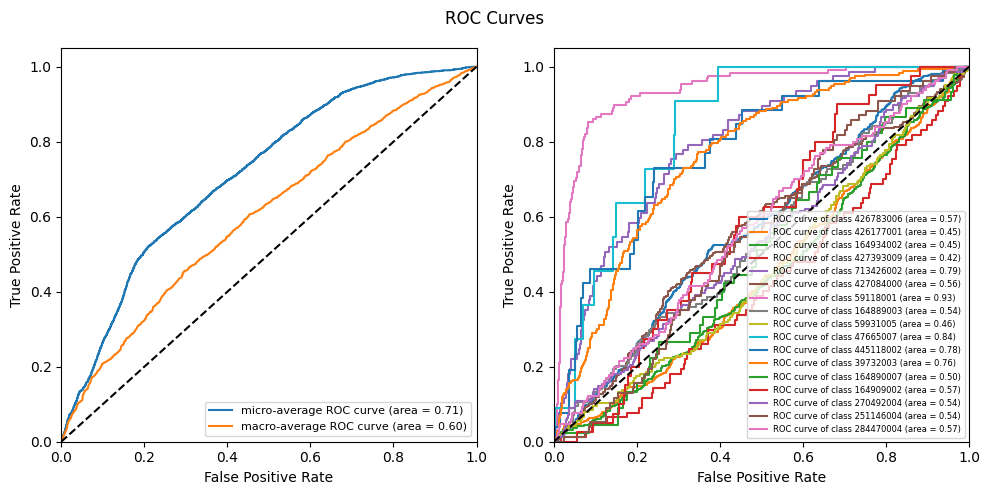

In [13]:
hist = p.evaluate(roc_curves_notebook)

## Feature extraction

For fast finetuning, we extract the vector representation of input data

In [14]:
def extract_model_split(m, splits, split_num, labels, device="cuda"):
    def g2c(t):
        return t.detach().cpu().numpy()
    res = {}
    for k in splits:
        dl = dataloader(splits[k][split_num], train=False)
        p = Extract(m, dl, labels, device)
        hist = p.predict_proba()
        res[k] = g2c(hist["logits_all"]), g2c(hist["ag_all"]), g2c(hist["labels_all"])
    return res


Feature extractor is basically a model without the classifier head

In [15]:
seresnet18.set_seed(RANDOM_SEED)

Setting seed to 42


In [ ]:
ex = seresnet18.ExtractorAgeECG8(seresnet18.BasicBlock,
                seresnet18.ARCH_PLANES["v4"],
                [2, 2, 2, 2],
                in_channel=IN_CHANNELS, out_channel=len(CINC_LABELS))
m_extractor = ModelBase(ex, CINC_LABELS, device)
m_extractor.set_weights(pretrained_weights)

In [17]:
features = extract_model_split(m_extractor.model, splits, SPLIT_NUM, CINC_LABELS, device)

1   /  25 predictions made
11  /  25 predictions made
21  /  25 predictions made
1   /   4 predictions made
1   /   3 predictions made
1   /   7 predictions made


In [18]:
# ECG features
features["train"][0].shape

(6354, 74)

In [19]:
# age/gender features
features["train"][1].shape

(6354, 3)

In [20]:
# labels
features["train"][2].shape

(6354, 17)

## Finetuning

For finetuning, we use the extracted features and a separate classifier head. Age and gender are already baked into the 74-element vector and are not needed separately.

In [21]:
X, _, y = features["train"]

In [22]:
train_ds = feat_dataloader(X, y, train=True, device=device)

In [23]:
X, _, y = features["val"]

In [24]:
val_ds = feat_dataloader(X, y, train=False, device=device)

In [25]:
model = seresnet18.finetuning_model("classif", len(CINC_LABELS), "v4")

In [26]:
t = TrainAndSelect(model, adamopt, train_ds, val_ds, CINC_LABELS, device, ".", name=f"ft_classifier_{SPLIT_NUM}",
            patience=10)
t.update_weights(pretrained_weights)
t.cp_freq = None # no checkpoints

Turn the log off. Classifier training is very fast, so we can afford 100-s of epochs.

In [27]:
hist_finetune = t.train(400, log=False)

In [28]:
def train_val_loss(hist):
    x = np.arange(len(hist["train_loss"]))
    plt.plot(x, hist["train_loss"], label="train loss")
    plt.plot(x, hist["val_loss"], label="val loss")
    plt.legend()
    plt.show()

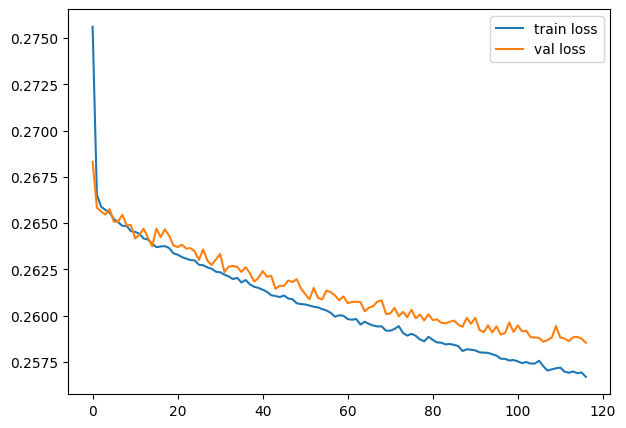

In [29]:
train_val_loss(hist_finetune)

### Finetuned model on test split

In [ ]:
model = seresnet18.resnet18(RANDOM_SEED, "v4", in_channel=IN_CHANNELS, out_channel=len(CINC_LABELS))
m_finetuned = ModelBase(model, CINC_LABELS, device)
m_finetuned.set_weights(pretrained_weights)

Glue the finetuned classifier to the full model

In [31]:
m_finetuned.set_classifier(t.best_model)

In [32]:
# test_ds was loaded earlier
p = Predict(m_finetuned.model, test_ds, CINC_LABELS, device)

1   /   7 predictions made
macro avg prec: 0.160  micro avg prec: 0.237  macro auroc: 0.663  micro auroc: 0.778  


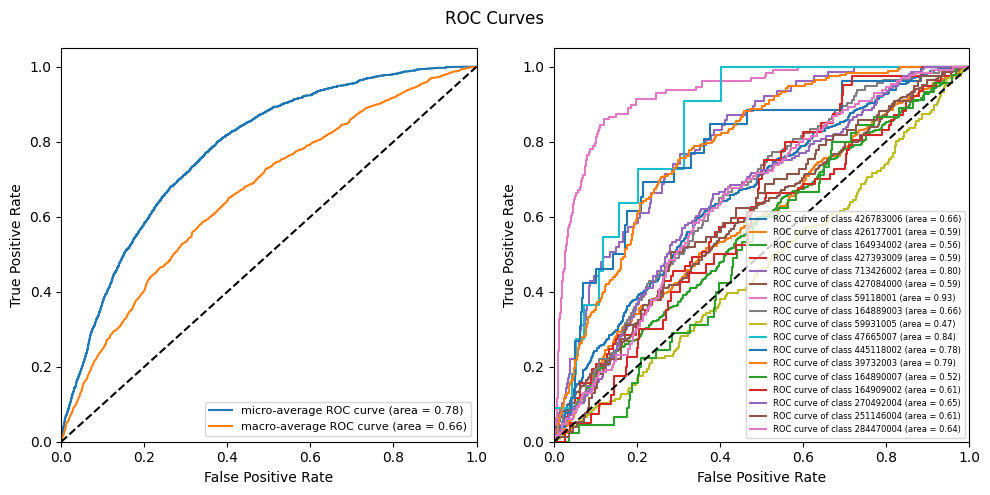

In [33]:
hist_eval = p.evaluate(roc_curves_notebook)